In [1]:
import psycopg2, pandas as pd

In [2]:
def query_database(connection, sql, *args, **kwargs):
    if connection.get_transaction_status() == 3:
        connection.reset()
    with connection.cursor() as cursor:
        cursor.execute(sql, *args, **kwargs)
        rows = cursor.fetchall()
        columns = [d[0] for d in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [3]:
connection = psycopg2.connect('postgres://fga@localhost/fga')

new users

* APP_STARTUP
* action = loaded, param = SIGNUP PAGE
* register as gues
* open_tutorialpage
* tutorial_dismiss
* (homepage_loaded)
* initialize_quiz (not found, perhaps you meant start_quiz?)
* finalize quiz submit


in first 10 minutes

### events

In [32]:
sql = '''
select 
    action,
    count(1)
    
from events

group by 1

order by 2 desc

'''

df = query_database(connection, sql)
df

,action,count
0,LOADED,456718
1,CONSTRUCTOR,133903
2,APP_PAUSED,129570
3,START_QUIZ,88717
4,APP_STARTUP,85075
5,APP_COMPONENT_StartApp,84701
6,APP_RESUMED,75827
7,COMPETITION_CLICK,69508
8,HeyzapAds_STARTED,36056
9,registerHeyzapAds_IncentivizedAd_fetch,35309


In [35]:
df[df['action'].str.contains('quiz', case=False)]

,action,count
3,START_QUIZ,88717
12,SUMMARY_QUIZ,21525
20,FINALIZE_QUIZ_SUBMIT,17


In [30]:
sql = ''' select * from events limit 1 '''
df = query_database(connection, sql)
df.head()

,id,version,createdAt,updatedAt,deleted,info,warn,error,previosPage,currentPage,action,subAction,params,currentUser,currentUserProfile,userDevice,userCountry
0,00000ef7-44bf-44e9-bb16-e452a683d872,\x0000000000cd7cc1,2019-10-17 22:34:12.3162084 +00:00,2019-10-17 22:34:12.3162084 +00:00,False,True,False,False,OFFERS,OFFERS,APP_PAUSED,,0.0,35e9ef31-386d-4701-988d-c228f25df219,02674699-E2E3-4933-AB6E-CE33573FE39A,A8D3D978-2387-4EB6-B995-846FD2DC473A,us


In [66]:
sql = '''
with events as (
    select 
        id as event_id,
        action,
        "currentUser" as user_id,
        "userDevice" as device_id,
        "createdAt"::timestamp as ts,
        "DeviceOS" as client
        
    from events join devices 
        on "userDevice" = "Id"
    
    where action in (
      'APP_STARTUP', 
      'LOADED', 
      'REGISTER_AS_GUEST', 
      'OPEN_TutorialPage', 
      'TUTORIAL_DISMISS', 
      'START_QUIZ', 
      'FINALIZE_QUIZ_SUBMIT'
    )

), session_starts as (
    select
        event_id,
        user_id,
        device_id,
        client,
        ts
        
    from events
    
    where action = 'APP_STARTUP'
    
), action_count as (
    select
        action,
        count(1)
        
    from events
    
    group by 1
    
), session_events as (
    select
        session_starts.event_id as start_event,
        session_starts.ts as start_ts,
        user_id,
        device_id,
        client,
        events.event_id,
        events.ts,
        action
        
    from events join session_starts
        using (user_id, device_id, client)

    where events.ts >= session_starts.ts
        and events.ts < session_starts.ts + interval '10 minutes'

), session_events_seen as (
    select
        start_event,
        start_ts,
        user_id,
        device_id,
        client,
        action,
        count(1)
        
    from session_events
    
    group by 1, 2, 3, 4, 5, 6

), session_events_seen_by_date as (
    select
        start_ts::date as date,
        client,
        action,
        count(1)
        
    from session_events_seen
    
    group by 1, 2, 3
    
    order by 1, 3 desc

), sessions_by_date as (
    select
        ts::date as date,
        client,
        count(1)
        
    from session_starts
    
    group by 1, 2
    
    order by 1

), loading_funnel as (
    select
        date,
        client,
        action,
        session_events_seen_by_date.count::float / sessions_by_date.count as percent
        
    from session_events_seen_by_date join sessions_by_date
        using (date, client)
        
)

select * from loading_funnel

'''

df = query_database(connection, sql)
df.head()

,date,client,action,percent
0,2019-10-14,iOS,APP_STARTUP,1.000000
1,2019-10-14,iOS,LOADED,0.814220
2,2019-10-14,iOS,START_QUIZ,0.504587
3,2019-10-14,Android,APP_STARTUP,1.000000
4,2019-10-14,Android,LOADED,0.822222


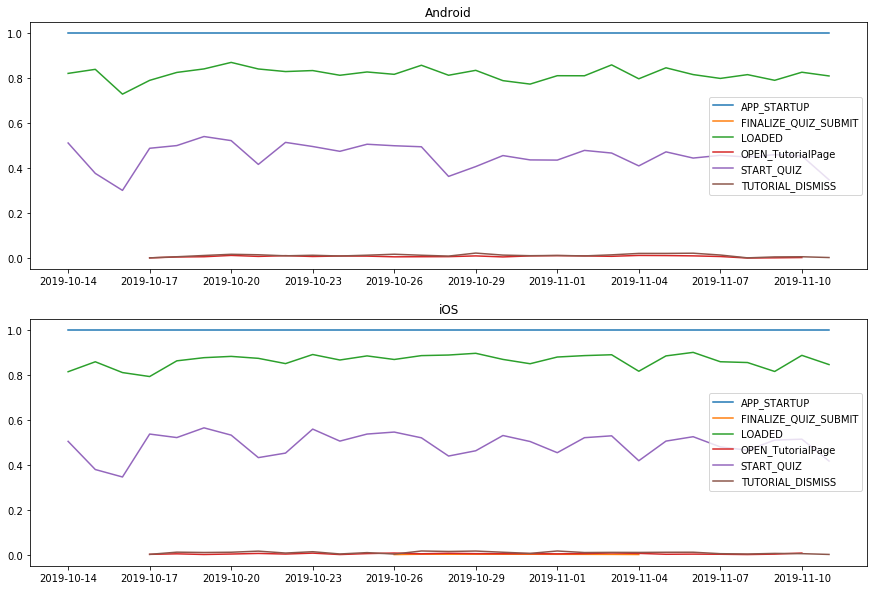

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
for i, (client, df_) in enumerate(df.groupby('client')):
    ax = axes[i]
    for action, df__ in df_.groupby('action'):
        ax.plot(df__['date'], df__['percent'], label=action)
    ax.legend()
    ax.set_title(client)